# Examine if the important mobility ties are structural

- Compute the diameters of the spatial + mobility networks
- Separate them based on the activity categories for analysis.


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import copy
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize


Bad key text.latex.unicode in file /home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')


In [2]:
import sys
sys.path.append("../")
import utils

In [3]:
import importlib
importlib.reload(utils)

<module 'utils' from '../utils.py'>

In [4]:
# read files
with open("../../data/02_intermediate/boston_stays.pickle", 'rb') as f:
    df_boston = pickle.load(f)

with open("../../data/02_intermediate/miami_stays.pickle", 'rb') as f:
    df_miami = pickle.load(f)

with open("../../data/02_intermediate/chicago_stays.pickle", 'rb') as f:
    df_chicago = pickle.load(f)

with open("../../data/03_processed/A_home_activity_three_cities_unweighted_dic.pickle", 'rb') as f:
    A_home_activity_unweighted_dic = pickle.load(f)
    
with open("../../data/03_processed/A_home_activity_three_cities_weighted_dic.pickle", 'rb') as f:
    A_home_activity_weighted_dic = pickle.load(f)


In [5]:
with open("../../data/03_processed/spatial_network_boston_miami_chicago_dic.pickle", 'rb') as f:
    spatial_network_dic = pickle.load(f)


In [6]:
# read shapefiles
with open("../../data/02_intermediate/boston_miami_chicago_ct_shp_dic.pickle", 'rb') as f:
    shp_dic = pickle.load(f)


In [7]:
# read evaluation files
with open("../../data/05_model_outputs/lasso_coefficients.pickle", 'rb') as f:
    lasso_coef = pickle.load(f)


In [59]:
lasso_coef['boston'].keys()

dict_keys(['inc_median_household_2018', 'property_value_median_2018', 'rent_median_2018'])

In [9]:
# activity counts for the three cities
# boston
activity_counts_boston = np.unique(df_boston.cat, return_counts = True)

# miami
activity_counts_miami = np.unique(df_miami.cat, return_counts = True)

# chicago
activity_counts_chicago = np.unique(df_chicago.cat, return_counts = True)

# convert the counts to df
activity_counts_dic = {}
activity_counts_dic['boston']=activity_counts_boston
activity_counts_dic['miami']=activity_counts_miami
activity_counts_dic['chicago']=activity_counts_chicago

# turn them to dataframes
activity_counts_df_dic = {}
for key_ in activity_counts_dic.keys():
    activity_counts = activity_counts_dic[key_]
    activity_count_df = pd.DataFrame(activity_counts[1],
                                 index = activity_counts[0],
                                 columns = ['count'])
    sorted_activity_count_df = activity_count_df.sort_values('count', ascending=False)
    activity_counts_df_dic[key_] = sorted_activity_count_df


### Compute diameters (spatial + X graphs)

In [25]:
# init
network_property_dic = {}

# fixed parameters
spatial_net_name = 'queen_contiguity_adj_df'
model_type = 'lasso (no socio-demographics)'
threshold = 1.0
# top_K_as_strong_mobility_ties = 50
# sampling_size = 10 # number of samples we need from each activity list (strong, weak insig, etc.)

for city in ['boston', 'chicago', 'miami']:
    # init cities
    # city = 'chicago'
    # city = 'boston'
    # city = 'miami'
    network_property_dic[city] = {}

    # need to try and test if the spatial net is connected. 
    # if not, use only the largest component for the analysis. 
    spatial_net = spatial_network_dic[city][spatial_net_name]
    G_spatial = nx.from_pandas_adjacency(spatial_net)

    if nx.number_connected_components(G_spatial) > 1:
        # if city = chicago or miami, then the network is disconnected. We choose the giant component. 
        # find the giant component
        Gcc = sorted(nx.connected_components(G_spatial), key=len, reverse=True)
        for G_sub in Gcc:
            print(len(G_sub)) # print the size of the components.
        G0 = G_spatial.subgraph(Gcc[0])
        giant_component_node_list = sorted(list(G0.nodes))
        giant_component_node_list

        # replace the input shapefile and the spatial networks
        spatial_network_dic[city][spatial_net_name] = spatial_network_dic[city][spatial_net_name].loc[giant_component_node_list, giant_component_node_list]
        shp_dic[city] = shp_dic[city].loc[giant_component_node_list, :]

        # recreate the spatial net and spatial graph
        spatial_net = spatial_network_dic[city][spatial_net_name]
        G_spatial = nx.from_pandas_adjacency(spatial_net)

    print(city)
    print("Baseline average distance: ", nx.average_shortest_path_length(G_spatial))

    # iterate over the 600+ mobility graphs for each city. compute the average distance
    activity_list = list(activity_counts_df_dic[city].index)
    for idx in range(len(activity_list)):
        activity_name = activity_list[idx]
        print(idx)
        print(activity_name)
        
        spatial_net = spatial_network_dic[city][spatial_net_name]
        mobility_net = utils.turn_df_to_adj(A_home_activity_unweighted_dic[city][threshold][activity_name], shp_dic[city])

        # integrate networks and compute betweenness centralities 
        integrated_adj = spatial_net.add(mobility_net, fill_value = 0.0)
        integrated_adj.values[integrated_adj.values > 1.0] = 1.0 # valid adj matrices

        # Get the edge betweenness metrics
        G = nx.from_pandas_adjacency(integrated_adj)
        network_property_dic[city][activity_name] = nx.average_shortest_path_length(G)
    

boston
Baseline average distance:  13.718757120536441
0
Office
1
Residential
2
Building
3
Automotive
4
Church
5
Salon / Barbershop
6
Doctor's Office
7
Pizza
8
American
9
Gas Station
10
Gym
11
Road
12
Bank
13
Donuts
14
Hardware
15
Grocery Store
16
Supermarket
17
Bar
18
Dentist's Office
19
Convenience Store
20
Pharmacy
21
Park
22
Gym / Fitness
23
Hospital
24
School
25
Coffee Shop
26
Medical
27
Sandwiches
28
Department Store
29
Big Box Store
30
Italian
31
High School
32
Playground
33
Hotel
34
Laundry
35
Café
36
Liquor Store
37
Neighborhood
38
Fast Food
39
Auto Dealer
40
Bus
41
Coworking Space
42
Shop
43
Chinese
44
Tech Startup
45
Residence Hall
46
Nail Salon
47
Other Outdoors
48
Entertainment
49
Pool
50
Professional
51
Furniture / Home
52
Library
53
Speakeasy
54
Apparel
55
Event Space
56
Lounge
57
Elementary School
58
Government
59
Bakery
60
Breakfast
61
Factory
62
Sporting Goods
63
Parking
64
Post Office
65
Fire Station
66
Academic Building
67
Spa
68
Art Gallery
69
Baseball Field
70
Cosm

543
Canal Lock
544
Check Cashing Service
545
Preserve
546
Convention
547
Drugstore
548
Argentinian
549
Astrologer
550
Luggage Store
551
Street Food Gathering
552
Pitch
553
Cruise
554
Village
555
Street Art
556
South Indian
557
Peking Duck
558
English
559
Fishing Spot
560
Pastry
561
Indian Chinese
562
Souvenir Shop
563
Badminton Court
564
Bowling Green
565
Knitting Supplies
566
Laser Tag
567
Airport Service
568
Tennis
569
Adult Boutique
570
Toll Plaza
571
Fireworks Store
572
Soba
573
Heliport
574
Christmas Market
575
Afghan
576
Outdoor Supplies
577
Food Service
578
Monastery
579
Cricket
580
Venezuelan
581
Kosher
582
RV Park
583
Country Dance Club
584
Nudist Beach
585
Tibetan
586
Pop-Up Shop
587
Halal
588
Belgian
589
Hunan
590
Toll Booth
591
Dive Shop
592
Used Bookstore
593
Shanghai
594
Poutine Place
595
Paella
596
Boat Rental
597
Palace
598
Medical Supply
599
Chairlift
600
Prayer Room
601
Empanada
602
Adult Education Center
603
Baggage Locker
604
Cave
605
Mobility Store
606
Jewish
607
H

455
Opera House
456
Fish Market
457
Campaign
458
Motorsports Shop
459
Planetarium
460
Photo Studio
461
EV Charging
462
Residence
463
Australian
464
Bubble Tea
465
Prison
466
Laboratory
467
History
468
Chocolate Shop
469
Lodge
470
Shopping Plaza
471
Pedestrian Street/Plaza
472
Film Studio
473
Kitchen Supply
474
Tram
475
Roller Rink
476
Corporate Amenity
477
Halal
478
Convention
479
Apres Ski Bar
480
Border Crossing
481
Boarding
482
Botanical Garden
483
Climbing Gym
484
Alternative Healer
485
Locksmith
486
Forest
487
Souvenir Shop
488
Argentinian
489
Ramen
490
Pop-Up Shop
491
Embassy
492
Amphitheater
493
Fountain
494
Vape Store
495
Tiki Bar
496
Art Studio
497
Cheese Shop
498
Comfort Food
499
Entertainment Service
500
Perfume Shop
501
Carpet Store
502
Ski Chalet
503
Palace
504
Tunnel
505
Boxing Gym
506
Peruvian
507
Mini Golf
508
Bath House
509
Recruiting Agency
510
Polish
511
Christmas Market
512
Hindu Temple
513
Tour Provider
514
Russian
515
Cantonese
516
RV Park
517
Maternity Clinic
518

343
Tourist Information
344
Gourmet
345
Embassy
346
Gun Range
347
Baggage Claim
348
Dry Cleaner
349
Bridal
350
Train
351
Exhibit
352
Piano Bar
353
Adult Boutique
354
Museum
355
Village
356
Boxing Gym
357
Board Shop
358
Airport Service
359
Laundromat
360
Zoo
361
Fish Market
362
Art Museum
363
Bistro
364
Beach Bar
365
Tapas
366
Cajun / Creole
367
Well
368
County
369
Fair
370
Rec Center
371
Law School
372
Mountain
373
Basketball
374
Campaign
375
Fountain
376
Tea Room
377
Cruise
378
Bus Stop
379
German
380
Lighthouse
381
Event Services
382
Insurance Office
383
Tailor
384
Chocolate Shop
385
Skating Rink
386
Sake Bar
387
Health Food Store
388
Mac & Cheese
389
Vietnamese
390
Golf Driving Range
391
Currency Exchange
392
Religious School
393
Music School
394
Indie
395
Aquarium
396
Pawn Shop
397
Technology
398
Country Dance Club
399
Camera Store
400
Opera House
401
Toll Plaza
402
Outdoor Supplies
403
Rock Climbing
404
Fabric Shop
405
Flight School
406
African
407
Eastern European
408
Other Event

### Assigning labels to activity categories

## save

In [27]:
with open('../../data/05_model_outputs/network_property_diameters.pickle', 'wb') as f:
    pickle.dump(network_property_dic, f)


## open

In [28]:
with open('../../data/05_model_outputs/network_property_diameters.pickle', 'rb') as f:
    network_property_dic = pickle.load(f)


In [30]:
network_property_dic[city]

{'Residential': 1.92360730336215,
 'Office': 1.8754810574809242,
 'Building': 1.8950871924691124,
 'Pool': 2.051928585703817,
 'Housing Development': 2.330219377584643,
 'Automotive': 2.013587471751485,
 'Church': 2.1418190762671476,
 "Doctor's Office": 1.9531625525896394,
 'Grocery Store': 2.036370764003833,
 'Road': 2.0428096319109574,
 'Gym': 2.077407337183501,
 'Salon / Barbershop': 1.9961746001650071,
 'Park': 2.1938475886913698,
 'Gas Station': 1.9860743147332982,
 'Fast Food': 1.9716797425477726,
 'American': 1.9704037551949083,
 'Hardware': 2.0949073243723833,
 'Bank': 2.091204911270197,
 'Gym / Fitness': 2.2451714896255566,
 'Bar': 2.005298678405067,
 'Medical': 2.1538948360945565,
 'Shop': 2.1070010197649927,
 'Pizza': 2.0854885904183087,
 'Auto Dealer': 2.190455204644799,
 "Dentist's Office": 2.1654069067299364,
 'Entertainment': 2.0955683780612167,
 'Elementary School': 2.690222042297187,
 'Hotel': 2.0364706907242383,
 'School': 2.448668412395013,
 'Hospital': 2.17918142080

In [31]:
# assigne the diameters to categories
network_diameter_activity_cat_dic = {}
top_K_as_strong_mobility_ties = 50


for city in ['boston', 'chicago', 'miami']:
    print(city)
    network_diameter_activity_cat_dic[city] = {}
    for output_var in ['inc_median_household_2018', 'property_value_median_2018', 'rent_median_2018']:
        print(output_var)
        network_diameter_activity_cat_dic[city][output_var] = {}
        
        network_diameter_activity_cat_dic[city][output_var]['strong'] = {}
        network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'] = {}
        network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'] = {}
        network_diameter_activity_cat_dic[city][output_var]['weak_insig'] = {}
        
        # create the four activity lists
        strong_activity_list = list(activity_counts_df_dic[city].index[:top_K_as_strong_mobility_ties]) # top 50.
        weak_sig_activity_list = list(lasso_coef[city][output_var][model_type].index)
        weak_sig_neg_activities = list(lasso_coef[city][output_var][model_type]['value'].loc[lasso_coef[city][output_var][model_type]['value'] < 0.0].index)
        weak_sig_pos_activities = list(lasso_coef[city][output_var][model_type]['value'].loc[lasso_coef[city][output_var][model_type]['value'] > 0.0].index)
        weak_insig_activity_list = list(set(activity_counts_df_dic[city].index).difference(set(strong_activity_list)).difference(set(weak_sig_activity_list)))

        activity_list_dic = {}
        activity_list_dic['strong'] = strong_activity_list
        activity_list_dic['weak_sig_neg'] = weak_sig_neg_activities
        activity_list_dic['weak_sig_pos'] = weak_sig_pos_activities
        activity_list_dic['weak_insig'] = weak_insig_activity_list

        # check and assign values.
        for activity_name in network_property_dic[city].keys():
            # four ifs - because they are not mutually exclusive...(weak sig vs. strong)
            if activity_name in activity_list_dic['strong']:
                network_diameter_activity_cat_dic[city][output_var]['strong'][activity_name]=network_property_dic[city][activity_name]
            if activity_name in activity_list_dic['weak_sig_neg']:
                network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'][activity_name]=network_property_dic[city][activity_name]
            if activity_name in activity_list_dic['weak_sig_pos']:
                network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'][activity_name]=network_property_dic[city][activity_name]
            if activity_name in activity_list_dic['weak_insig']:
                network_diameter_activity_cat_dic[city][output_var]['weak_insig'][activity_name]=network_property_dic[city][activity_name]
    


boston
inc_median_household_2018
property_value_median_2018
rent_median_2018
chicago
inc_median_household_2018
property_value_median_2018
rent_median_2018
miami
inc_median_household_2018
property_value_median_2018
rent_median_2018


### Analysis

In [34]:
# boston diameter baseline: 13.7
city = 'boston'
output_var = 'inc_median_household_2018'
diameter_df = pd.DataFrame([network_diameter_activity_cat_dic[city][output_var]['strong'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_insig'].values()],
                          index = activity_type_list).T

diameter_df.describe()

,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,50.000000,5.000000,10.000000,568.000000
mean,2.358012,3.762571,4.863348,5.279248
std,0.252608,0.388161,2.434682,2.700206
min,1.956036,3.362317,2.586211,2.100752
25%,2.168316,3.465439,3.093068,3.292639
50%,2.288616,3.763086,3.844517,4.348035
75%,2.493181,3.875028,6.569336,6.210760
max,3.010363,4.346984,8.743219,13.718757


In [35]:
# boston diameter baseline: 13.7
city = 'boston'
output_var = 'property_value_median_2018'
diameter_df = pd.DataFrame([network_diameter_activity_cat_dic[city][output_var]['strong'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_insig'].values()],
                          index = activity_type_list).T

diameter_df.describe()

,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,50.000000,9.000000,6.000000,569.000000
mean,2.358012,3.374584,3.669548,5.300785
std,0.252608,0.538761,0.626782,2.705092
min,1.956036,2.476354,3.147672,2.100752
25%,2.168316,3.096416,3.355728,3.303433
50%,2.288616,3.362317,3.464345,4.357510
75%,2.493181,3.763086,3.665924,6.305524
max,3.010363,4.188920,4.888287,13.718757


In [36]:
# boston diameter baseline: 13.7
city = 'boston'
output_var = 'rent_median_2018'
diameter_df = pd.DataFrame([network_diameter_activity_cat_dic[city][output_var]['strong'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_insig'].values()],
                          index = activity_type_list).T

diameter_df.describe()

,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,50.000000,6.000000,9.000000,568.000000
mean,2.358012,3.852496,4.614349,5.284181
std,0.252608,0.514399,2.443948,2.700817
min,1.956036,3.348638,3.111554,2.100752
25%,2.168316,3.433560,3.446675,3.287926
50%,2.288616,3.773901,3.967673,4.345539
75%,2.493181,4.162281,4.664063,6.252359
max,3.010363,4.606684,10.934098,13.718757


In [37]:
# chicago diameter baseline: 15.8
city = 'chicago'
output_var = 'inc_median_household_2018'
diameter_df = pd.DataFrame([network_diameter_activity_cat_dic[city][output_var]['strong'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_insig'].values()],
                          index = activity_type_list).T

diameter_df.describe()

,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,50.000000,4.000000,11.000000,587.000000
mean,2.265821,3.687232,4.546159,5.040268
std,0.248087,0.937477,3.015227,2.891246
min,1.945181,2.495759,2.577799,2.065764
25%,2.089126,3.180134,2.950938,3.054377
50%,2.198645,3.830172,3.047201,3.981291
75%,2.403701,4.337270,4.275001,5.926500
max,3.082643,4.592824,11.434695,15.919317


In [38]:
# chicago diameter baseline: 15.8
city = 'chicago'
output_var = 'property_value_median_2018'
diameter_df = pd.DataFrame([network_diameter_activity_cat_dic[city][output_var]['strong'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_insig'].values()],
                          index = activity_type_list).T

diameter_df.describe()

,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,50.000000,5.000000,10.000000,587.000000
mean,2.265821,3.365130,4.986038,5.036981
std,0.248087,0.891558,3.052715,2.891967
min,1.945181,2.495759,2.577799,2.065764
25%,2.089126,3.005847,3.050097,3.048375
50%,2.198645,3.066263,3.832230,3.985056
75%,2.403701,3.408259,5.116708,5.926500
max,3.082643,4.849525,11.464166,15.919317


In [39]:
# chicago diameter baseline: 15.8
city = 'chicago'
output_var = 'rent_median_2018'
diameter_df = pd.DataFrame([network_diameter_activity_cat_dic[city][output_var]['strong'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_insig'].values()],
                          index = activity_type_list).T

diameter_df.describe()

,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,50.000000,3.000000,12.000000,587.000000
mean,2.265821,3.780223,4.868079,5.031749
std,0.248087,1.125349,2.733353,2.895282
min,1.945181,2.495759,2.693867,2.065764
25%,2.089126,3.373922,3.036700,3.048375
50%,2.198645,4.252086,3.660249,3.977778
75%,2.403701,4.422455,5.291340,5.912686
max,3.082643,4.592824,10.279738,15.919317


In [40]:
# miami 
city = 'miami'
output_var = 'inc_median_household_2018'
diameter_df = pd.DataFrame([network_diameter_activity_cat_dic[city][output_var]['strong'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_insig'].values()],
                          index = activity_type_list).T

diameter_df.describe()

,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,50.000000,4.000000,11.000000,565.000000
mean,2.159669,3.382853,5.032756,5.826416
std,0.180585,1.112849,5.293534,4.874378
min,1.875481,2.509613,2.216346,2.067233
25%,2.038055,2.691390,2.682333,2.978997
50%,2.109814,3.021606,2.957677,4.032515
75%,2.240642,3.713069,3.181527,6.286403
max,2.690222,4.978585,19.417619,25.131962


In [41]:
# miami 
city = 'miami'
output_var = 'property_value_median_2018'
diameter_df = pd.DataFrame([network_diameter_activity_cat_dic[city][output_var]['strong'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_insig'].values()],
                          index = activity_type_list).T

diameter_df.describe()

,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,50.000000,7.000000,8.000000,567.000000
mean,2.159669,2.632146,3.871073,5.847736
std,0.180585,0.645927,1.628766,4.905339
min,1.875481,1.971680,2.502695,2.067233
25%,2.038055,2.278208,2.946215,2.976515
50%,2.109814,2.509613,3.168116,4.032515
75%,2.240642,2.709394,4.163068,6.301721
max,2.690222,3.968526,7.077110,25.131962


In [42]:
# miami 
city = 'miami'
output_var = 'rent_median_2018'
diameter_df = pd.DataFrame([network_diameter_activity_cat_dic[city][output_var]['strong'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'].values(), 
               network_diameter_activity_cat_dic[city][output_var]['weak_insig'].values()],
                          index = activity_type_list).T

diameter_df.describe()

,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,50.000000,4.000000,11.000000,565.000000
mean,2.159669,3.880572,3.730976,5.848236
std,0.180585,1.263400,1.360646,4.915622
min,1.875481,2.509613,2.502695,2.067233
25%,2.038055,2.955644,2.938952,2.974695
50%,2.109814,4.017045,3.090136,3.968526
75%,2.240642,4.941973,3.983458,6.317039
max,2.690222,4.978585,6.338354,25.131962


### Combine the diameters

#### Total effect (boston + chicago + miami)

In [61]:
city_list = ['boston','chicago','miami']
output_var_list = ['inc_median_household_2018', 'property_value_median_2018', 'rent_median_2018']

diameter_dic = {}
diameter_dic['strong']=[]
diameter_dic['weak_sig_neg']=[]
diameter_dic['weak_sig_pos']=[]
diameter_dic['weak_insig']=[]

for city in city_list:
    for output_var in output_var_list:
        diameter_dic['strong'] += list(network_diameter_activity_cat_dic[city][output_var]['strong'].values())
        diameter_dic['weak_sig_neg'] += list(network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'].values())
        diameter_dic['weak_sig_pos'] += list(network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'].values())
        diameter_dic['weak_insig'] += list(network_diameter_activity_cat_dic[city][output_var]['weak_insig'].values())        


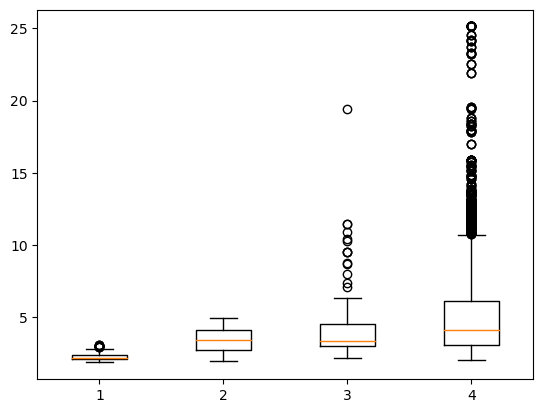

In [62]:
plt.boxplot([diameter_dic['strong'], 
             diameter_dic['weak_sig_neg'], 
             diameter_dic['weak_sig_pos'], 
             diameter_dic['weak_insig']])
plt.show()

In [63]:
# 
pd.DataFrame([diameter_dic['strong'], diameter_dic['weak_sig_neg'], 
              diameter_dic['weak_sig_pos'], diameter_dic['weak_insig']],
              index = ['strong', 'weak_sig_neg', 'weak_sig_pos', 'weak_insig']).T.describe()

,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,450.000000,47.000000,88.000000,5163.000000
mean,2.261168,3.461554,4.520848,5.383886
std,0.241454,0.822766,2.835950,3.639321
min,1.875481,1.971680,2.216346,2.065764
25%,2.088718,2.751982,2.993214,3.088615
50%,2.193812,3.408259,3.386044,4.102698
75%,2.411541,4.135641,4.541389,6.150902
max,3.082643,4.978585,19.417619,25.131962


In [64]:
# pairwise comparison
from scipy import stats
print(stats.ttest_ind(diameter_dic['strong'], diameter_dic['weak_sig_neg']))
print(stats.ttest_ind(diameter_dic['strong'], diameter_dic['weak_sig_pos']))
print(stats.ttest_ind(diameter_dic['weak_insig'], diameter_dic['weak_sig_neg']))
print(stats.ttest_ind(diameter_dic['weak_insig'], diameter_dic['weak_sig_pos']))


Ttest_indResult(statistic=-23.012411043193634, pvalue=3.1807872054977945e-80)
Ttest_indResult(statistic=-16.65912870574751, pvalue=1.6057587641435427e-50)
Ttest_indResult(statistic=3.620066385431703, pvalue=0.00029732613633476904)
Ttest_indResult(statistic=2.2130894670458527, pvalue=0.026934337481318398)


#### city effects (boston, chicago, miami)

In [47]:
city_list = ['boston','chicago','miami']
output_var_list = ['inc_median_household_2018', 'property_value_median_2018', 'rent_median_2018']

diameter_dic = {}

for city in city_list:
    diameter_dic[city] = {}
    diameter_dic[city]['strong']=[]
    diameter_dic[city]['weak_sig_neg']=[]
    diameter_dic[city]['weak_sig_pos']=[]
    diameter_dic[city]['weak_insig']=[]

    for output_var in output_var_list:
        diameter_dic[city]['strong'] += list(network_diameter_activity_cat_dic[city][output_var]['strong'].values())
        diameter_dic[city]['weak_sig_neg'] += list(network_diameter_activity_cat_dic[city][output_var]['weak_sig_neg'].values())
        diameter_dic[city]['weak_sig_pos'] += list(network_diameter_activity_cat_dic[city][output_var]['weak_sig_pos'].values())
        diameter_dic[city]['weak_insig'] += list(network_diameter_activity_cat_dic[city][output_var]['weak_insig'].values())        


##### boston

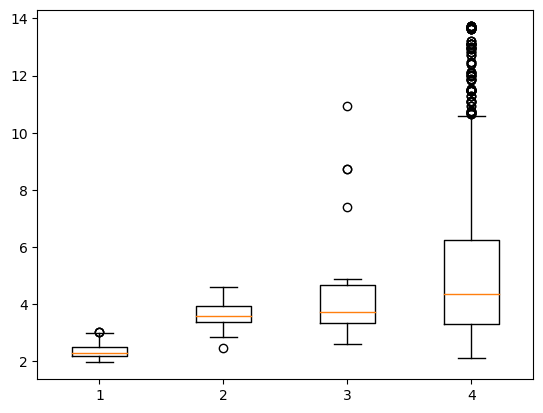

In [48]:
city = 'boston'
plt.boxplot([diameter_dic[city]['strong'], 
             diameter_dic[city]['weak_sig_neg'], 
             diameter_dic[city]['weak_sig_pos'], 
             diameter_dic[city]['weak_insig']])
plt.show()

In [51]:
# 
pd.DataFrame([diameter_dic[city]['strong'], diameter_dic[city]['weak_sig_neg'], 
              diameter_dic[city]['weak_sig_pos'], diameter_dic[city]['weak_insig']],
              index = ['strong', 'weak_sig_neg', 'weak_sig_pos', 'weak_insig']).T.describe()


,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,150.000000,15.000000,30.000000,1697.000000
mean,2.159669,3.165248,4.245654,5.840804
std,0.179369,1.043097,3.363854,4.895607
min,1.875481,1.971680,2.216346,2.067233
25%,2.036471,2.509613,2.748317,2.975600
50%,2.109814,2.751982,3.075965,3.984522
75%,2.245171,3.629878,3.828009,6.317039
max,2.690222,4.978585,19.417619,25.131962


In [52]:
# pairwise comparison
from scipy import stats
print(stats.ttest_ind(diameter_dic[city]['strong'], diameter_dic[city]['weak_sig_neg']))
print(stats.ttest_ind(diameter_dic[city]['strong'], diameter_dic[city]['weak_sig_pos']))
print(stats.ttest_ind(diameter_dic[city]['weak_insig'], diameter_dic[city]['weak_sig_neg']))
print(stats.ttest_ind(diameter_dic[city]['weak_insig'], diameter_dic[city]['weak_sig_pos']))


Ttest_indResult(statistic=-10.593911526273978, pvalue=2.780930792768062e-20)
Ttest_indResult(statistic=-7.626158557451916, pvalue=1.3983422742510166e-12)
Ttest_indResult(statistic=2.115660371394698, pvalue=0.034517927796375185)
Ttest_indResult(statistic=1.7769938215759777, pvalue=0.07574543698723668)


##### chicago

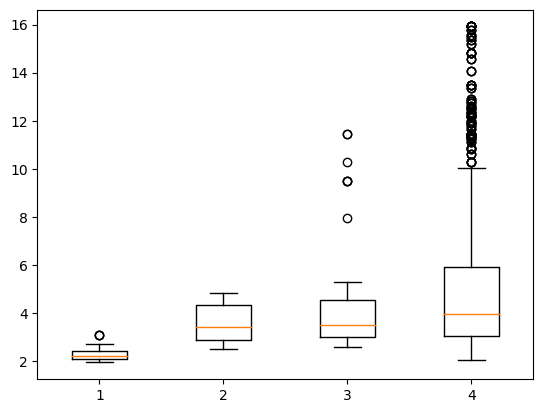

In [49]:
city = 'chicago'
plt.boxplot([diameter_dic[city]['strong'], 
             diameter_dic[city]['weak_sig_neg'], 
             diameter_dic[city]['weak_sig_pos'], 
             diameter_dic[city]['weak_insig']])
plt.show()

In [53]:
# 
pd.DataFrame([diameter_dic[city]['strong'], diameter_dic[city]['weak_sig_neg'], 
              diameter_dic[city]['weak_sig_pos'], diameter_dic[city]['weak_insig']],
              index = ['strong', 'weak_sig_neg', 'weak_sig_pos', 'weak_insig']).T.describe()


,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,150.000000,15.000000,30.000000,1697.000000
mean,2.159669,3.165248,4.245654,5.840804
std,0.179369,1.043097,3.363854,4.895607
min,1.875481,1.971680,2.216346,2.067233
25%,2.036471,2.509613,2.748317,2.975600
50%,2.109814,2.751982,3.075965,3.984522
75%,2.245171,3.629878,3.828009,6.317039
max,2.690222,4.978585,19.417619,25.131962


In [54]:
# pairwise comparison
from scipy import stats
print(stats.ttest_ind(diameter_dic[city]['strong'], diameter_dic[city]['weak_sig_neg']))
print(stats.ttest_ind(diameter_dic[city]['strong'], diameter_dic[city]['weak_sig_pos']))
print(stats.ttest_ind(diameter_dic[city]['weak_insig'], diameter_dic[city]['weak_sig_neg']))
print(stats.ttest_ind(diameter_dic[city]['weak_insig'], diameter_dic[city]['weak_sig_pos']))


Ttest_indResult(statistic=-10.593911526273978, pvalue=2.780930792768062e-20)
Ttest_indResult(statistic=-7.626158557451916, pvalue=1.3983422742510166e-12)
Ttest_indResult(statistic=2.115660371394698, pvalue=0.034517927796375185)
Ttest_indResult(statistic=1.7769938215759777, pvalue=0.07574543698723668)


##### miami

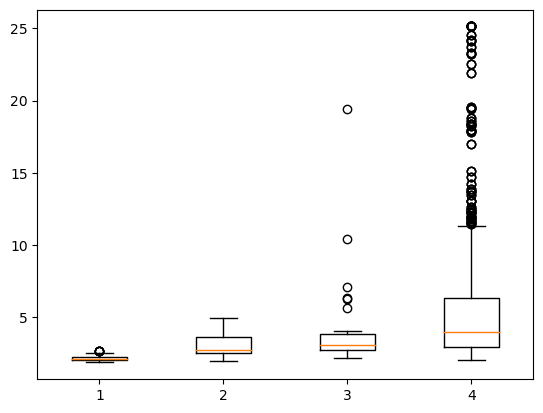

In [56]:
city = 'miami'
plt.boxplot([diameter_dic[city]['strong'], 
             diameter_dic[city]['weak_sig_neg'], 
             diameter_dic[city]['weak_sig_pos'], 
             diameter_dic[city]['weak_insig']])
plt.show()

In [57]:
# 
pd.DataFrame([diameter_dic[city]['strong'], diameter_dic[city]['weak_sig_neg'], 
              diameter_dic[city]['weak_sig_pos'], diameter_dic[city]['weak_insig']],
              index = ['strong', 'weak_sig_neg', 'weak_sig_pos', 'weak_insig']).T.describe()


,strong,weak_sig_neg,weak_sig_pos,weak_insig
count,150.000000,15.000000,30.000000,1697.000000
mean,2.159669,3.165248,4.245654,5.840804
std,0.179369,1.043097,3.363854,4.895607
min,1.875481,1.971680,2.216346,2.067233
25%,2.036471,2.509613,2.748317,2.975600
50%,2.109814,2.751982,3.075965,3.984522
75%,2.245171,3.629878,3.828009,6.317039
max,2.690222,4.978585,19.417619,25.131962


In [58]:
# pairwise comparison
from scipy import stats
print(stats.ttest_ind(diameter_dic[city]['strong'], diameter_dic[city]['weak_sig_neg']))
print(stats.ttest_ind(diameter_dic[city]['strong'], diameter_dic[city]['weak_sig_pos']))
print(stats.ttest_ind(diameter_dic[city]['weak_insig'], diameter_dic[city]['weak_sig_neg']))
print(stats.ttest_ind(diameter_dic[city]['weak_insig'], diameter_dic[city]['weak_sig_pos']))


Ttest_indResult(statistic=-10.593911526273978, pvalue=2.780930792768062e-20)
Ttest_indResult(statistic=-7.626158557451916, pvalue=1.3983422742510166e-12)
Ttest_indResult(statistic=2.115660371394698, pvalue=0.034517927796375185)
Ttest_indResult(statistic=1.7769938215759777, pvalue=0.07574543698723668)
